In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from scipy.io import savemat, loadmat
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import metrics, losses
from tensorflow.keras import backend as K

You can use the following keras tutorial for sequential models to implement and train your network in this problem.

https://keras.io/getting-started/sequential-model-guide/

# Part 1

In [6]:
# Load data
data = loadmat('P2_train.mat')
V = data['X']
Z = data['Y']
print(V.shape) #check the size of velocity

(20000, 451)


In [7]:
# ToDo: perform pca on velocity and call the e-vector matrix U
U,D,_ = np.linalg.svd(V.T, full_matrices='False')

In [9]:
# ToDo: Calculate the reconstruction RMSE and plot it. If necessary, try using an informative plot
# such as semi-log or log-log

# Initialize error vector:
svd_err_v=np.zeros((D.shape[0],1))
svd_err_v[0]=1

# Calculate RMSEs for different principal component numbers:
for i in range(D.shape[0]-1):
    err=U[:, :i+1].dot(U[:, :i+1].T.dot(V.T))-V.T
    svd_err_v[i+1]=np.sqrt(np.mean((err**2)))

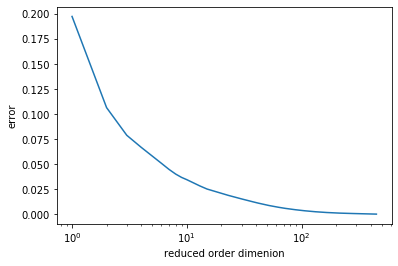

In [14]:
#plotting the errors:
plt.semilogx(np.arange(1,svd_err_v.shape[0]-1),svd_err_v[1:-1])
plt.xlabel('reduced dimenion')
plt.ylabel('error')
plt.show()

# Part 2

In [15]:
# ToDo: number of components to obtain 10% error
print(svd_err_v[45])

[0.01019149]


In [17]:
# Setting up input and output of the network, X_train and Y_train,
# after performing proper pre-training normalization of the data.
# ToDo: You have to set l equal to the proper number of components you calculated above.

# projection to low dimensional space:
l = 45
proj_v = U[:,:l].T.dot(V.T)
V_tr=proj_v.T

# normalization:
std_V = np.std(V_tr, 0)
std_V[std_V==0] = 1
mean_V = np.mean(V_tr,0)
std_Z = np.std(Z,0)
std_Z[std_Z==0] = 1
mean_Z = np.mean(Z,0)

# setting up the network input and output:
Y_train = (V_tr - mean_V)/std_V
X_train = (Z - mean_Z)/std_Z

# checking the size of input and output:
print(X_train.shape)
print(Y_train.shape)

(20000, 41)
(20000, 45)


In [ ]:
def generate_model(input_dim, output_dim, n_layer, n_hidden,
                   optimizer_meth, act_fcn, learning_rate = 0.001, reg=0.01):
    """
    input_dim:           the size of input vector
    output_dim:          the size of output vector
    n_layer:             number of hidden layers in the network
    n_hidden:            a list of number of hidden units in each hidden layer. 
                         for example, for n_hidden=3, this can be [200, 100, 45]
    optimizer_meth:      the optimization method used for training
    act_fcn              the type of activation function in the hidden layers
    learning_rate        Learning rate used in the training phase
    reg                  L2 regularization coefficient
    """
    # we build the first layer outside of the for loop:
    model = Sequential()  
    model.add(Dense(units=n_hidden[0],input_dim=input_dim,
                    kernel_regularizer = regularizers.l2(reg)))
    model.add(BatchNormalization())
    model.add(Activation(act_fcn))
    #### ToDo for part 2. Build your model here and compile it. You should copy-paste your code from Problem 1.
    """ hint: Keep the parameters for the hidden layers the same, and use for loop to add the layers to the 
              network. Add the last layer (output layer) outside the for loop since it has a different
              activation function. 
        
    """
    # loop to add the hidden layers:
    for i in range(1, n_layer):
        model.add(Dense(units=n_hidden[i],input_dim=n_hidden[i-1], kernel_regularizer = regularizers.l2(reg)))
        model.add(BatchNormalization())
        model.add(Activation(act_fcn))
    
    #final layer:
    model.add(Dense(units=output_dim, activation='linear',kernel_regularizer = regularizers.l2(reg)))
    
    #compiling the model:
    model.compile(loss='mean_squared_error', optimizer=optimizer_meth, metrics=['mse'])  
    
    return model

In [ ]:
def train(model, x_train, y_train, batch_s, n_epochs, verbose=1, validation_split=.2):
    """
    model:       the DNN model (the output of generate_model)
    x_train:     input of the network
    y_train:     output of the network
    batch_size:  batch size parameter
    epochs:      number of epochs used to train the network
    validation_split:  validation/train split ration
    """
    
    #### ToDo for part 2. Use the training data and train your model. You should copy-paste your code from Problem 1. 
    #### hint: Plot the loss function for the training and validation set to observe your network performance.
    
    #fitting the data to the DNN:
    history = model.fit(x_train, y_train, batch_size = batch_s, epochs = n_epochs, verbose=verbose, validation_split=validation_split,shuffle=False)
    #plot train loss:
    plt.plot(history.history['loss'],'b')
    #plot validation loss:
    plt.plot(history.history['val_loss'],'r')
    return history.history['val_mse']

In [ ]:
def hyp_tuning(learning_rate = [1e-4,1e-3,1e-2,1e-1], regularization = [1e-4,1e-3,1e-2,1e-1],n_layer=1,hidden_nodes=50):
    ### ToDo (optional) for part 2. Find the optimal combination of learning rate and regularization coefficient.
    ### You can copy-paste your code from Problem 1.
    
    # initialize number of epochs and batch size:
    epochs = 10
    batch_size = 256
    losses = np.zeros((len(learning_rate), len(regularization)))
    mses = np.zeros((len(learning_rate), len(regularization)))
    
    # use a for loop to train over different parameters:
    for lr in range(len(learning_rate)):
        for reg in range(len(regularization)):

            optimizer_meth = Adam(lr=learning_rate[lr], beta_1=0.9, beta_2=0.999, decay=2e-6, amsgrad=False)

            model = generate_model(X_train.shape[1], Y_train.shape[1], n_layer, hidden_nodes, optimizer_meth, 'tanh',
                                   learning_rate[lr], regularization[reg])
            mses[lr,reg] = train(model, X_train, Y_train, batch_size, epochs)[-1]

    # determine which hyperparameters are optimal:
    [lr_ind, reg_ind] = np.unravel_index(mses.argmin(), mses.shape)
    
    return learning_rate[lr_ind], regularization[reg_ind]

In [ ]:
# Don't change this block. It's for post-processing and plotting the results
def post_process_low_rank(data, U):
    nx = [501, 41]
    n_edge = 11
    a = np.zeros((nx[1], nx[0]))
    for i in range(data.shape[0]):
        a[:, i:i+n_edge] += np.dot(U, data[i, :]).reshape(nx[1], -1)
    for i in range(n_edge):
        a[:, i] = a[:, i]/(i+1)
        a[:, nx[0]-i-1] = a[:, nx[0]-i-1]/(i+1)

    a[:, n_edge: nx[0]-n_edge] = a[:, n_edge: nx[0]-n_edge]/n_edge
    return a

def post_process(data):
    nx = [501, 41]
    n_edge = 11
    a = np.zeros((nx[1], nx[0]))
    for i in range(data.shape[0]):
        a[:, i:i+n_edge] += data[i, :].reshape(nx[1], -1)
    for i in range(n_edge):
        a[:, i] = a[:, i]/(i+1)
        a[:, nx[0]-i-1] = a[:, nx[0]-i-1]/(i+1)

    a[:, n_edge: nx[0]-n_edge] = a[:, n_edge: nx[0]-n_edge]/n_edge
    return a

def plt_im_tri(depth, fig_name, show_file=True, vmin_=21, vmax_=29,label_z='Elevation [m]'):
    mesh = loadmat("mesh.mat")
    triangles = mesh['triangles']
    meshnode = mesh['meshnode']
    matplotlib.rcParams.update({'font.size': 16})

    offsetx = 220793.
    offsety = 364110.
    fig_index = 1
    plt.figure(fig_index, figsize=(10., 10.), dpi=100)
    fig_index += 1
    ax = plt.gca()
    im = plt.tripcolor(meshnode[:, 0]*0.3010-offsetx, meshnode[:, 1]*0.3010-offsety,
                       triangles, depth*0.301, cmap=plt.get_cmap('jet'), vmin=vmin_, vmax=vmax_, label='_nolegend_')
    ax.set_xlabel("Easting [m]")
    ax.set_ylabel("Northing [m]")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis([0., 1000., 0., 530.])
    plt.xticks(np.arange(0., 1000.+10., 200.0))
    plt.yticks(np.arange(0., 530.+10., 200.0))
    cbar = plt.colorbar(im, fraction=0.025, pad=0.05)
    cbar.set_label(label_z)
    plt.rcParams['axes.axisbelow'] = True
    plt.rc('axes', axisbelow=True)
    plt.grid()
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.savefig(fig_name)
    if show_file:
        plt.show()

def plot_inverse(model, mean_V=None, std_V=None, mean_Z=None, std_Z=None):
    data_red_river = loadmat('P2_test.mat')
    V = data_red_river['X']
    Z = data_red_river['Y']
    Uz = data_red_river['U']
    V_P = (V-mean_V)/std_V
    pred = model.predict(V_P)
    Z_P = pred*std_Z+mean_Z
    river_prof = post_process_low_rank(Z_P, Uz)
    plt_im_tri(river_prof.ravel(), 'predicted_river.jpg', False,21,29,label_z='Elevation [m]')
    
def plot_forward_low_rank(model, mean_Z=None, std_Z=None, mean_V=None, std_V=None, U_l=None):
    data_red_river = loadmat('P2_test.mat')
    V = data_red_river['X']
    Z = data_red_river['Y']
    Uz = data_red_river['U']
    Z_P = (Z-mean_Z)/std_Z
    pred = model.predict(Z_P)
    V_P = pred*std_V+mean_V
    velocity_prof = post_process_low_rank(V_P, U_l)
    plt_im_tri(velocity_prof.ravel(), 'predicted_velocity.jpg', False,-0.5,1,label_z='Velocity [m/s]')
    
def plot_forward(model, mean_Z=None, std_Z=None, mean_V=None, std_V=None):
    data_red_river = loadmat('P2_test.mat')
    V = data_red_river['X']
    Z = data_red_river['Y']
    Uz = data_red_river['U']
    Z_P = (Z-mean_Z)/std_Z
    pred = model.predict(Z_P)
    V_P = pred*std_V+mean_V
    velocity_prof = post_process(V_P)
    plt_im_tri(velocity_prof.ravel(), 'predicted_velocity.jpg', False,-0.5,1,label_z='Velocity [m/s]')

In [151]:
"""
ToDo:  
Train your network with output dimension=l. You can use your codes from problem 1
"""

# setting up parameters:
input_dim = X_train.shape[1]
output_dim = Y_train.shape[1]
n_layer = 8
n_hidden =  [600,500,400,300,250, 200,150,100]
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, decay=2e-6, amsgrad=False)

optimizer_meth = adam
act_fcn = 'tanh'
model = generate_model(input_dim, output_dim, n_layer, n_hidden,
                       optimizer_meth, act_fcn, learning_rate = 1e-4, reg=1e-3)
print(Y_train.shape)

(20000, 45)


Train on 16000 samples, validate on 4000 samples
Epoch 1/2000
16000/16000 [==============================] - 3s 189us/step - loss: 3.3156 - mse: 1.0740 - val_loss: 3.0524 - val_mse: 0.8340
Epoch 2/2000
16000/16000 [==============================] - 2s 96us/step - loss: 3.0542 - mse: 0.8636 - val_loss: 2.9365 - val_mse: 0.7768
Epoch 3/2000
16000/16000 [==============================] - 1s 91us/step - loss: 2.9270 - mse: 0.7991 - val_loss: 2.8317 - val_mse: 0.7378
Epoch 4/2000
16000/16000 [==============================] - 1s 88us/step - loss: 2.8156 - mse: 0.7553 - val_loss: 2.7330 - val_mse: 0.7082
Epoch 5/2000
16000/16000 [==============================] - 1s 88us/step - loss: 2.7114 - mse: 0.7210 - val_loss: 2.6385 - val_mse: 0.6841
Epoch 6/2000
16000/16000 [==============================] - 1s 92us/step - loss: 2.6120 - mse: 0.6920 - val_loss: 2.5476 - val_mse: 0.6635
Epoch 7/2000
16000/16000 [==============================] - 1s 84us/step - loss: 2.5168 - mse: 0.6666 - val_loss: 2.

16000/16000 [==============================] - 1s 87us/step - loss: 0.4865 - mse: 0.2132 - val_loss: 0.6650 - val_mse: 0.3925
Epoch 118/2000
16000/16000 [==============================] - 1s 87us/step - loss: 0.4842 - mse: 0.2127 - val_loss: 0.6630 - val_mse: 0.3922
Epoch 119/2000
16000/16000 [==============================] - 1s 82us/step - loss: 0.4821 - mse: 0.2122 - val_loss: 0.6583 - val_mse: 0.3892
Epoch 120/2000
16000/16000 [==============================] - 1s 88us/step - loss: 0.4800 - mse: 0.2117 - val_loss: 0.6545 - val_mse: 0.3869
Epoch 121/2000
16000/16000 [==============================] - 1s 80us/step - loss: 0.4778 - mse: 0.2110 - val_loss: 0.6529 - val_mse: 0.3869
Epoch 122/2000
16000/16000 [==============================] - 1s 81us/step - loss: 0.4760 - mse: 0.2108 - val_loss: 0.6516 - val_mse: 0.3872
Epoch 123/2000
16000/16000 [==============================] - 1s 78us/step - loss: 0.4751 - mse: 0.2114 - val_loss: 0.6518 - val_mse: 0.3889
Epoch 124/2000
16000/16000 [

16000/16000 [==============================] - 1s 86us/step - loss: 0.3456 - mse: 0.1696 - val_loss: 0.5302 - val_mse: 0.3543
Epoch 234/2000
16000/16000 [==============================] - 1s 90us/step - loss: 0.3446 - mse: 0.1689 - val_loss: 0.5296 - val_mse: 0.3541
Epoch 235/2000
16000/16000 [==============================] - 1s 91us/step - loss: 0.3440 - mse: 0.1687 - val_loss: 0.5321 - val_mse: 0.3570
Epoch 236/2000
16000/16000 [==============================] - 1s 93us/step - loss: 0.3436 - mse: 0.1687 - val_loss: 0.5332 - val_mse: 0.3584
Epoch 237/2000
16000/16000 [==============================] - 1s 92us/step - loss: 0.3437 - mse: 0.1692 - val_loss: 0.5315 - val_mse: 0.3571
Epoch 238/2000
16000/16000 [==============================] - 1s 80us/step - loss: 0.3451 - mse: 0.1709 - val_loss: 0.5253 - val_mse: 0.3513
Epoch 239/2000
16000/16000 [==============================] - 1s 84us/step - loss: 0.3454 - mse: 0.1716 - val_loss: 0.5274 - val_mse: 0.3537
Epoch 240/2000
16000/16000 [

16000/16000 [==============================] - 1s 82us/step - loss: 0.2989 - mse: 0.1508 - val_loss: 0.4814 - val_mse: 0.3334
Epoch 350/2000
16000/16000 [==============================] - 1s 85us/step - loss: 0.2986 - mse: 0.1506 - val_loss: 0.4771 - val_mse: 0.3292
Epoch 351/2000
16000/16000 [==============================] - 1s 84us/step - loss: 0.2992 - mse: 0.1514 - val_loss: 0.4782 - val_mse: 0.3304
Epoch 352/2000
16000/16000 [==============================] - 1s 87us/step - loss: 0.2996 - mse: 0.1519 - val_loss: 0.4861 - val_mse: 0.3385
Epoch 353/2000
16000/16000 [==============================] - 1s 88us/step - loss: 0.3010 - mse: 0.1535 - val_loss: 0.4889 - val_mse: 0.3414
Epoch 354/2000
16000/16000 [==============================] - 1s 89us/step - loss: 0.3015 - mse: 0.1541 - val_loss: 0.4872 - val_mse: 0.3398
Epoch 355/2000
16000/16000 [==============================] - 2s 94us/step - loss: 0.3016 - mse: 0.1543 - val_loss: 0.4859 - val_mse: 0.3386
Epoch 356/2000
16000/16000 [

16000/16000 [==============================] - 1s 87us/step - loss: 0.2785 - mse: 0.1414 - val_loss: 0.4548 - val_mse: 0.3177
Epoch 466/2000
16000/16000 [==============================] - 1s 80us/step - loss: 0.2787 - mse: 0.1417 - val_loss: 0.4553 - val_mse: 0.3183
Epoch 467/2000
16000/16000 [==============================] - 1s 78us/step - loss: 0.2788 - mse: 0.1418 - val_loss: 0.4559 - val_mse: 0.3190
Epoch 468/2000
16000/16000 [==============================] - 1s 81us/step - loss: 0.2794 - mse: 0.1426 - val_loss: 0.4528 - val_mse: 0.3160
Epoch 469/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2779 - mse: 0.1411 - val_loss: 0.4535 - val_mse: 0.3167
Epoch 470/2000
16000/16000 [==============================] - 1s 80us/step - loss: 0.2776 - mse: 0.1409 - val_loss: 0.4560 - val_mse: 0.3193
Epoch 471/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2777 - mse: 0.1410 - val_loss: 0.4545 - val_mse: 0.3179
Epoch 472/2000
16000/16000 [

16000/16000 [==============================] - 1s 79us/step - loss: 0.2687 - mse: 0.1369 - val_loss: 0.4398 - val_mse: 0.3081
Epoch 582/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2679 - mse: 0.1361 - val_loss: 0.4414 - val_mse: 0.3096
Epoch 583/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2675 - mse: 0.1357 - val_loss: 0.4405 - val_mse: 0.3088
Epoch 584/2000
16000/16000 [==============================] - 1s 80us/step - loss: 0.2676 - mse: 0.1359 - val_loss: 0.4407 - val_mse: 0.3090
Epoch 585/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2676 - mse: 0.1359 - val_loss: 0.4430 - val_mse: 0.3114
Epoch 586/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2687 - mse: 0.1370 - val_loss: 0.4425 - val_mse: 0.3109
Epoch 587/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2688 - mse: 0.1372 - val_loss: 0.4420 - val_mse: 0.3104
Epoch 588/2000
16000/16000 [

16000/16000 [==============================] - 1s 80us/step - loss: 0.2580 - mse: 0.1300 - val_loss: 0.4380 - val_mse: 0.3099
Epoch 698/2000
16000/16000 [==============================] - 1s 86us/step - loss: 0.2573 - mse: 0.1293 - val_loss: 0.4341 - val_mse: 0.3061
Epoch 699/2000
16000/16000 [==============================] - 1s 87us/step - loss: 0.2568 - mse: 0.1289 - val_loss: 0.4344 - val_mse: 0.3065
Epoch 700/2000
16000/16000 [==============================] - 1s 83us/step - loss: 0.2569 - mse: 0.1290 - val_loss: 0.4392 - val_mse: 0.3113
Epoch 701/2000
16000/16000 [==============================] - 1s 83us/step - loss: 0.2577 - mse: 0.1298 - val_loss: 0.4367 - val_mse: 0.3088
Epoch 702/2000
16000/16000 [==============================] - 1s 81us/step - loss: 0.2572 - mse: 0.1294 - val_loss: 0.4424 - val_mse: 0.3145
Epoch 703/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2578 - mse: 0.1300 - val_loss: 0.4381 - val_mse: 0.3102
Epoch 704/2000
16000/16000 [

16000/16000 [==============================] - 1s 88us/step - loss: 0.2510 - mse: 0.1255 - val_loss: 0.4266 - val_mse: 0.3010
Epoch 814/2000
16000/16000 [==============================] - 1s 92us/step - loss: 0.2512 - mse: 0.1257 - val_loss: 0.4314 - val_mse: 0.3059
Epoch 815/2000
16000/16000 [==============================] - 1s 83us/step - loss: 0.2523 - mse: 0.1268 - val_loss: 0.4304 - val_mse: 0.3048
Epoch 816/2000
16000/16000 [==============================] - 1s 89us/step - loss: 0.2540 - mse: 0.1285 - val_loss: 0.4324 - val_mse: 0.3069
Epoch 817/2000
16000/16000 [==============================] - 1s 90us/step - loss: 0.2542 - mse: 0.1287 - val_loss: 0.4353 - val_mse: 0.3098
Epoch 818/2000
16000/16000 [==============================] - 1s 85us/step - loss: 0.2550 - mse: 0.1295 - val_loss: 0.4396 - val_mse: 0.3141
Epoch 819/2000
16000/16000 [==============================] - 1s 83us/step - loss: 0.2541 - mse: 0.1286 - val_loss: 0.4346 - val_mse: 0.3091
Epoch 820/2000
16000/16000 [

16000/16000 [==============================] - 1s 83us/step - loss: 0.2457 - mse: 0.1218 - val_loss: 0.4241 - val_mse: 0.3001
Epoch 930/2000
16000/16000 [==============================] - 1s 83us/step - loss: 0.2460 - mse: 0.1222 - val_loss: 0.4272 - val_mse: 0.3033
Epoch 931/2000
16000/16000 [==============================] - 1s 84us/step - loss: 0.2462 - mse: 0.1223 - val_loss: 0.4322 - val_mse: 0.3084
Epoch 932/2000
16000/16000 [==============================] - 1s 83us/step - loss: 0.2464 - mse: 0.1226 - val_loss: 0.4283 - val_mse: 0.3045
Epoch 933/2000
16000/16000 [==============================] - 1s 83us/step - loss: 0.2466 - mse: 0.1228 - val_loss: 0.4306 - val_mse: 0.3068
Epoch 934/2000
16000/16000 [==============================] - 1s 84us/step - loss: 0.2474 - mse: 0.1236 - val_loss: 0.4313 - val_mse: 0.3075
Epoch 935/2000
16000/16000 [==============================] - 1s 84us/step - loss: 0.2486 - mse: 0.1248 - val_loss: 0.4348 - val_mse: 0.3110
Epoch 936/2000
16000/16000 [

Epoch 1045/2000
16000/16000 [==============================] - 1s 86us/step - loss: 0.2420 - mse: 0.1194 - val_loss: 0.4206 - val_mse: 0.2981
Epoch 1046/2000
16000/16000 [==============================] - 1s 87us/step - loss: 0.2424 - mse: 0.1199 - val_loss: 0.4165 - val_mse: 0.2940
Epoch 1047/2000
16000/16000 [==============================] - 1s 84us/step - loss: 0.2418 - mse: 0.1193 - val_loss: 0.4225 - val_mse: 0.3000
Epoch 1048/2000
16000/16000 [==============================] - 1s 82us/step - loss: 0.2417 - mse: 0.1192 - val_loss: 0.4245 - val_mse: 0.3019
Epoch 1049/2000
16000/16000 [==============================] - 1s 82us/step - loss: 0.2427 - mse: 0.1202 - val_loss: 0.4271 - val_mse: 0.3045
Epoch 1050/2000
16000/16000 [==============================] - 1s 81us/step - loss: 0.2426 - mse: 0.1200 - val_loss: 0.4259 - val_mse: 0.3033
Epoch 1051/2000
16000/16000 [==============================] - 1s 80us/step - loss: 0.2428 - mse: 0.1203 - val_loss: 0.4229 - val_mse: 0.3003
Epoch 

Epoch 1160/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2391 - mse: 0.1176 - val_loss: 0.4256 - val_mse: 0.3041
Epoch 1161/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2389 - mse: 0.1173 - val_loss: 0.4227 - val_mse: 0.3011
Epoch 1162/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2386 - mse: 0.1171 - val_loss: 0.4189 - val_mse: 0.2974
Epoch 1163/2000
16000/16000 [==============================] - 1s 80us/step - loss: 0.2384 - mse: 0.1169 - val_loss: 0.4191 - val_mse: 0.2975
Epoch 1164/2000
16000/16000 [==============================] - 1s 80us/step - loss: 0.2386 - mse: 0.1171 - val_loss: 0.4174 - val_mse: 0.2959
Epoch 1165/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2393 - mse: 0.1178 - val_loss: 0.4202 - val_mse: 0.2987
Epoch 1166/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2394 - mse: 0.1179 - val_loss: 0.4196 - val_mse: 0.2981
Epoch 

Epoch 1275/2000
16000/16000 [==============================] - 1s 78us/step - loss: 0.2352 - mse: 0.1147 - val_loss: 0.4205 - val_mse: 0.3000
Epoch 1276/2000
16000/16000 [==============================] - 1s 86us/step - loss: 0.2355 - mse: 0.1150 - val_loss: 0.4199 - val_mse: 0.2994
Epoch 1277/2000
16000/16000 [==============================] - 1s 83us/step - loss: 0.2363 - mse: 0.1158 - val_loss: 0.4166 - val_mse: 0.2961
Epoch 1278/2000
16000/16000 [==============================] - 1s 83us/step - loss: 0.2379 - mse: 0.1174 - val_loss: 0.4221 - val_mse: 0.3015
Epoch 1279/2000
16000/16000 [==============================] - 1s 78us/step - loss: 0.2382 - mse: 0.1177 - val_loss: 0.4193 - val_mse: 0.2988
Epoch 1280/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2385 - mse: 0.1180 - val_loss: 0.4186 - val_mse: 0.2981
Epoch 1281/2000
16000/16000 [==============================] - 1s 82us/step - loss: 0.2385 - mse: 0.1180 - val_loss: 0.4196 - val_mse: 0.2991
Epoch 

Epoch 1390/2000
16000/16000 [==============================] - 1s 88us/step - loss: 0.2339 - mse: 0.1140 - val_loss: 0.4165 - val_mse: 0.2966
Epoch 1391/2000
16000/16000 [==============================] - 1s 87us/step - loss: 0.2343 - mse: 0.1144 - val_loss: 0.4151 - val_mse: 0.2952
Epoch 1392/2000
16000/16000 [==============================] - 1s 84us/step - loss: 0.2349 - mse: 0.1150 - val_loss: 0.4107 - val_mse: 0.2908
Epoch 1393/2000
16000/16000 [==============================] - 1s 80us/step - loss: 0.2357 - mse: 0.1158 - val_loss: 0.4129 - val_mse: 0.2930
Epoch 1394/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2364 - mse: 0.1164 - val_loss: 0.4167 - val_mse: 0.2968
Epoch 1395/2000
16000/16000 [==============================] - 1s 78us/step - loss: 0.2370 - mse: 0.1171 - val_loss: 0.4201 - val_mse: 0.3001
Epoch 1396/2000
16000/16000 [==============================] - 1s 78us/step - loss: 0.2364 - mse: 0.1164 - val_loss: 0.4162 - val_mse: 0.2962
Epoch 

Epoch 1505/2000
16000/16000 [==============================] - 1s 82us/step - loss: 0.2811 - mse: 0.1615 - val_loss: 0.4785 - val_mse: 0.3583
Epoch 1506/2000
16000/16000 [==============================] - 1s 85us/step - loss: 0.3769 - mse: 0.2560 - val_loss: 0.5082 - val_mse: 0.3865
Epoch 1507/2000
16000/16000 [==============================] - 1s 90us/step - loss: 0.3474 - mse: 0.2255 - val_loss: 0.4366 - val_mse: 0.3144
Epoch 1508/2000
16000/16000 [==============================] - 1s 93us/step - loss: 0.2752 - mse: 0.1530 - val_loss: 0.4080 - val_mse: 0.2858
Epoch 1509/2000
16000/16000 [==============================] - 1s 86us/step - loss: 0.2485 - mse: 0.1264 - val_loss: 0.3983 - val_mse: 0.2763
Epoch 1510/2000
16000/16000 [==============================] - 1s 86us/step - loss: 0.2376 - mse: 0.1157 - val_loss: 0.3962 - val_mse: 0.2743
Epoch 1511/2000
16000/16000 [==============================] - 1s 85us/step - loss: 0.2321 - mse: 0.1102 - val_loss: 0.3968 - val_mse: 0.2750
Epoch 

Epoch 1620/2000
16000/16000 [==============================] - 1s 82us/step - loss: 0.2327 - mse: 0.1137 - val_loss: 0.4099 - val_mse: 0.2908
Epoch 1621/2000
16000/16000 [==============================] - 2s 110us/step - loss: 0.2322 - mse: 0.1132 - val_loss: 0.4129 - val_mse: 0.2939
Epoch 1622/2000
16000/16000 [==============================] - 2s 94us/step - loss: 0.2329 - mse: 0.1138 - val_loss: 0.4130 - val_mse: 0.2939
Epoch 1623/2000
16000/16000 [==============================] - 2s 100us/step - loss: 0.2322 - mse: 0.1132 - val_loss: 0.4136 - val_mse: 0.2945
Epoch 1624/2000
16000/16000 [==============================] - 2s 101us/step - loss: 0.2320 - mse: 0.1129 - val_loss: 0.4186 - val_mse: 0.2995
Epoch 1625/2000
16000/16000 [==============================] - 2s 106us/step - loss: 0.2318 - mse: 0.1128 - val_loss: 0.4143 - val_mse: 0.2953
Epoch 1626/2000
16000/16000 [==============================] - 2s 103us/step - loss: 0.2323 - mse: 0.1133 - val_loss: 0.4103 - val_mse: 0.2912
E

Epoch 1735/2000
16000/16000 [==============================] - 1s 90us/step - loss: 0.2298 - mse: 0.1115 - val_loss: 0.4092 - val_mse: 0.2908
Epoch 1736/2000
16000/16000 [==============================] - 2s 101us/step - loss: 0.2303 - mse: 0.1119 - val_loss: 0.4111 - val_mse: 0.2928
Epoch 1737/2000
16000/16000 [==============================] - 1s 89us/step - loss: 0.2301 - mse: 0.1118 - val_loss: 0.4109 - val_mse: 0.2926
Epoch 1738/2000
16000/16000 [==============================] - 1s 84us/step - loss: 0.2302 - mse: 0.1119 - val_loss: 0.4111 - val_mse: 0.2928
Epoch 1739/2000
16000/16000 [==============================] - 1s 90us/step - loss: 0.2304 - mse: 0.1121 - val_loss: 0.4101 - val_mse: 0.2918
Epoch 1740/2000
16000/16000 [==============================] - 1s 83us/step - loss: 0.2298 - mse: 0.1115 - val_loss: 0.4053 - val_mse: 0.2870
Epoch 1741/2000
16000/16000 [==============================] - 1s 88us/step - loss: 0.2292 - mse: 0.1109 - val_loss: 0.4092 - val_mse: 0.2909
Epoch

Epoch 1850/2000
16000/16000 [==============================] - 1s 83us/step - loss: 0.2278 - mse: 0.1098 - val_loss: 0.4104 - val_mse: 0.2924
Epoch 1851/2000
16000/16000 [==============================] - 1s 82us/step - loss: 0.2299 - mse: 0.1119 - val_loss: 0.4134 - val_mse: 0.2955
Epoch 1852/2000
16000/16000 [==============================] - 1s 84us/step - loss: 0.2316 - mse: 0.1136 - val_loss: 0.4145 - val_mse: 0.2965
Epoch 1853/2000
16000/16000 [==============================] - 1s 83us/step - loss: 0.2329 - mse: 0.1150 - val_loss: 0.4168 - val_mse: 0.2989
Epoch 1854/2000
16000/16000 [==============================] - 1s 82us/step - loss: 0.2332 - mse: 0.1153 - val_loss: 0.4181 - val_mse: 0.3002
Epoch 1855/2000
16000/16000 [==============================] - 1s 82us/step - loss: 0.2336 - mse: 0.1157 - val_loss: 0.4173 - val_mse: 0.2994
Epoch 1856/2000
16000/16000 [==============================] - 1s 83us/step - loss: 0.2333 - mse: 0.1154 - val_loss: 0.4154 - val_mse: 0.2975
Epoch 

Epoch 1965/2000
16000/16000 [==============================] - 1s 79us/step - loss: 0.2293 - mse: 0.1112 - val_loss: 0.4049 - val_mse: 0.2868
Epoch 1966/2000
16000/16000 [==============================] - 1s 90us/step - loss: 0.2285 - mse: 0.1104 - val_loss: 0.4024 - val_mse: 0.2843
Epoch 1967/2000
16000/16000 [==============================] - 1s 86us/step - loss: 0.2275 - mse: 0.1095 - val_loss: 0.4054 - val_mse: 0.2874
Epoch 1968/2000
16000/16000 [==============================] - 1s 86us/step - loss: 0.2270 - mse: 0.1090 - val_loss: 0.4070 - val_mse: 0.2890
Epoch 1969/2000
16000/16000 [==============================] - 1s 87us/step - loss: 0.2268 - mse: 0.1089 - val_loss: 0.4079 - val_mse: 0.2899
Epoch 1970/2000
16000/16000 [==============================] - 1s 87us/step - loss: 0.2268 - mse: 0.1089 - val_loss: 0.4056 - val_mse: 0.2877
Epoch 1971/2000
16000/16000 [==============================] - 1s 86us/step - loss: 0.2269 - mse: 0.1091 - val_loss: 0.4073 - val_mse: 0.2894
Epoch 

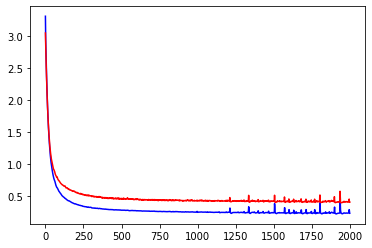

In [152]:
batch_s=256
n_epochs = 2000
train(model, X_train, Y_train, batch_s, n_epochs, verbose=1, validation_split=.2)

In [154]:
# ToDo: calculate RMSE of validation set of velocity. Note that the network output is 
# low-dimensional velocity after normalization. Make sure you convert these outputs to velocities.
pred = model.predict(X_train)
V_P = pred*std_V+mean_V 
V_P=U[:,:l].dot(V_P.T) #predicted velocities
print(np.sqrt(np.mean((V_P[:,:16000].T-V[:16000,:])**2))) #RMSE of train set
print(np.sqrt(np.mean((V_P[:,16000:].T-V[16000:,:])**2))) #RMSE of validation set

0.09664907781120284
0.133761892712901


In [155]:
# Calculation of RMSE of the test data. Here we use post_process function to calculate RMSE on the whole 
# river instead of small segments. You do not need to use post_process for RMSE of validation set asked above 

# load test dataset: 
data_red_river = loadmat('P2_test.mat')
V_test = data_red_river['X']
Z_test = data_red_river['Y']
Uz = data_red_river['U']
Z_P = (Z_test-mean_Z)/std_Z

#predict test set velocity RMSE using your trained network:
pred = model.predict(Z_P)
V_P = pred*std_V+mean_V
velocity_prof = post_process_low_rank(V_P,U[:,:l])
velocity_prof_true = post_process(V_test)
print(np.sqrt(np.mean((velocity_prof-velocity_prof_true)**2))) #RMSE

0.12279076381198312
